# MultiClass Text classification for the ICU ventilator adverse events reports in 2020


In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import chi2
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import itertools
import string
import io
import re
pd.options.display.max_colwidth=500
df=pd.read_csv("CBK2020transformed.csv")
df=df.drop(df.columns[[0]], axis = 1)
df = df.sample(frac=1).reset_index(drop=False)
df=df.drop(df.columns[[0]], axis = 1)
print(len(pd.DataFrame(df)))
df.head()

5383


,Device_Problems,Event_description,Narrative,Event_description_Narrative
0,Calibration_Problems,it was reported to resmed that an astral device failed to complete its internal selftest there was no patient harm or serious injury reported as a result of this incident,the device was returned to resmed and an evaluation confirmed the complaint the pneumatic block sensor circuit board was replaced to address the issue the device was serviced and fully tested before it was returned to the customer resmed reference b4,it was reported to resmed that an astral device failed to complete its internal selftest there was no patient harm or serious injury reported as a result of this incidentthe device was returned to resmed and an evaluation confirmed the complaint the pneumatic block sensor circuit board was replaced to address the issue the device was serviced and fully tested before it was returned to the customer resmed reference b4
1,Circuit_failure,the customer reported that the avea ventilator has an internal leak there is no patient involvement,b4 any additional information received from the customer will be included in a followup report at this time the suspect device has not been returned for evaluation therefore no root cause could be determined yet,the customer reported that the avea ventilator has an internal leak there is no patient involvementb4 any additional information received from the customer will be included in a followup report at this time the suspect device has not been returned for evaluation therefore no root cause could be determined yet
2,Mechanical_Problems,the customer reported to vyaire that lap top ventilator 1200 ventilator stated an error not to use it is also not working or cycling the issue occurred during patientuse the customer confirmed that there was no patient harm associated with the reported event,at this time the suspect device has not been returned for evaluation therefore no root cause could be determine yet vyaire medical will submit a supplemental report in accordance with 21 cfr section 803 56 if additional information becomes available,the customer reported to vyaire that lap top ventilator 1200 ventilator stated an error not to use it is also not working or cycling the issue occurred during patientuse the customer confirmed that there was no patient harm associated with the reported eventat this time the suspect device has not been returned for evaluation therefore no root cause could be determine yet vyaire medical will submit a supplemental report in accordance with 21 cfr section 803 56 if additional information become...
3,Mechanical_Problems,the customer reported that the ltv 1200 ventilator was sucked into the mri and the unit shuts on and off intermittently the issue occurred during patientuse and the device was replaced with another ventilator the customer confirmed that there was no patient harm associated with the reported event,the suspect device was returned and evaluation is anticipated but not yet begun once a final investigation is complete a followup report will be submitted any additional information received from the customer will be included in a followup report,the customer reported that the ltv 1200 ventilator was sucked into the mri and the unit shuts on and off intermittently the issue occurred during patientuse and the device was replaced with another ventilator the customer confirmed that there was no patient harm associated with the reported eventthe suspect device was returned and evaluation is anticipated but not yet begun once a final investigation is complete a followup report will be submitted any additional information received from the...
4,Circuit_failure,the customer reported that the revel has o2 leak led array damaged and broken pigtail as of this time there was no information about patient involvement associated with this reported event,the defective unit was evaluated by the third party service technician the led assembly and pigtail was replaced vy

# Number of reports for each Device_problem category 

In [2]:
Names_red_DP_list=['Calibration_Problems','Software_Problems','Circuit_failure','Power_Problems','Mechanical_Problems']
Names_DP_list=['Calibration','Software','Circuit','Power','Mechanical']
for i in range(0, len(Names_red_DP_list)):
    df.Device_Problems= df.Device_Problems.replace(Names_red_DP_list[i],Names_DP_list[i])
print('Number_Of_Device_Problems =',len(pd.DataFrame(df.Device_Problems.value_counts())))
(pd.DataFrame(df.Device_Problems.value_counts()))

Number_Of_Device_Problems = 5


,Device_Problems
Mechanical,1937
Circuit,1566
Calibration,1186
Power,612
Software,82


# Device_problems bars plot

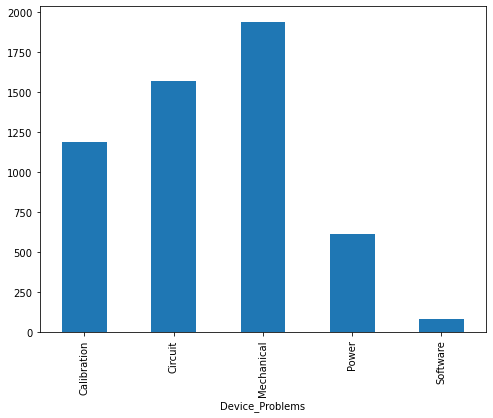

In [4]:
fig = plt.figure(figsize=(8,6))
df.groupby('Device_Problems').Event_description_Narrative.count().plot.bar(ylim=0)
plt.show()

# Working with Event_description_Narrative column

In [5]:
col = ['Device_Problems', 'Event_description_Narrative']
df= df[col]
df= df[pd.notnull(df['Event_description_Narrative'])]
#result = result[pd.notnull(result['Event_description'])]
df.columns = ['Device_Problems', 'Event_description_Narrative']
df['category_id'] =df['Device_Problems'].factorize()[0]
category_id_df= df[['Device_Problems', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category= dict(category_id_df[['category_id', 'Device_Problems']].values)
print(len(df))
df.sample(n=3)

5383


,Device_Problems,Event_description_Narrative,category_id
5270,Mechanical,the customer reported that the vela ventilator was alarming high pip and low pip the issue occurred during patientuse and the device was replaced with another ventilator the customer confirmed that there was no patient harm associated with the reported eventat this time the suspect device has not been returned for evaluation no root cause has been determined yet any additional information received from the customer will be included in a followup report,2
3015,Mechanical,the customer reported that the vela ventilator was alarming transducer fault on startup the customer confirmed that there was no patient involvement associated with the reported eventvyaire medical file identification b4 a vyaire field service representativefsr evaluated the device onsitechecked the error log and confirmed the alarms the unit was tested with personal test equipment and was unable to duplicate transducer fault but the vent would intermittently auto cycle during testing the pe...,2
3487,Circuit,it was reported to resmed that an astral device displayed a battery charging alarm there was no patient harm or a serious injury reported as a result of this incidentthe device was returned to resmed and an evaluation was performed the reported complaint could not be reproduced however review of the device data logs confirmed the reported complaint the internal battery was replaced to address the issue the device was serviced and fully tested before it was returned to the customer resmed ref...,1


# Feature extraction using TF-IDF

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2',
                        encoding='latin-1', ngram_range=(1, 2), 
                        stop_words='english')
features = tfidf.fit_transform(df["Event_description_Narrative"]).toarray()
labels = df.category_id
features.shape

(5383, 5258)

# Most Correlated Unigrams and Bigrams

In [7]:
N = 10
for Device_Problems, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Device_Problems))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Calibration':
  . Most correlated unigrams:
. incidentthe
. pneumatic
. internal
. failed
. block
. nonreturn
. nrv
. resmed
. complete
. selftest
  . Most correlated bigrams:
. nrv assembly
. valve nrv
. complaint pneumatic
. pneumatic block
. nonreturn valve
. device failed
. selftest patient
. internal selftest
. complete internal
. failed complete
# 'Circuit':
  . Most correlated unigrams:
. complaints
. event
. activities
. selftest
. unanticipated
. b6
. 2020
. date
. getinge
. display
  . Most correlated bigrams:
. submitted complaints
. b6 2020
. date report
. selftest patient
. failed complete
. complete internal
. event b6
. internal selftest
. device failed
. getinge b4
# 'Mechanical':
  . Most correlated unigrams:
. root
. medical
. information
. fault
. suspect
. associated
. additional
. vela
. resmed
. vyaire
  . Most correlated bigrams:
. cfr section
. root cause
. transducer fault
. involvement associated
. cause determined
. evaluation root
. associated reported
. 

# Models acuuracy

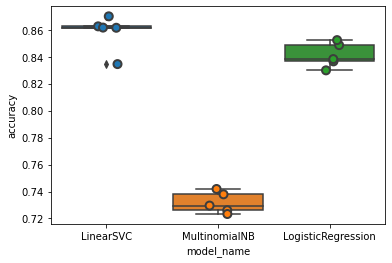

In [8]:
models = [
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [9]:
pd.DataFrame(cv_df.groupby('model_name').accuracy.mean())

,accuracy
model_name,
LinearSVC,0.858068
LogisticRegression,0.841164
MultinomialNB,0.731749


# Model Evaluation using Confusion Matrix

# Multinomial Naieve Bayes 

(4306, 5258) (1077, 5258) (4306,) (1077,)


Text(0.5, 69.0, 'Predicted')

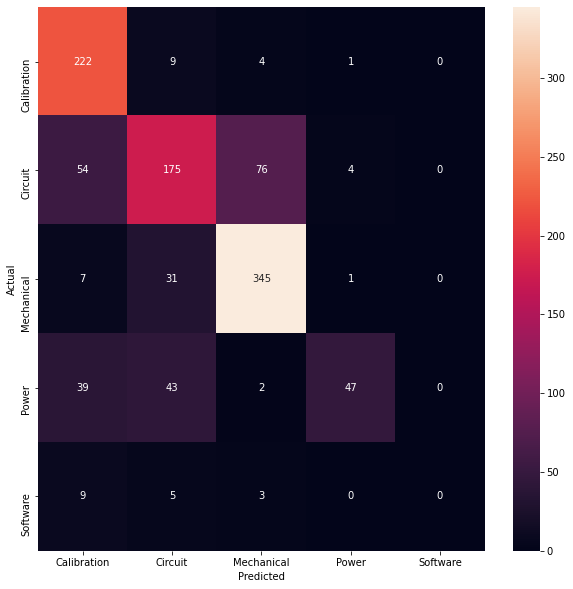

In [10]:
model = MultinomialNB()
X_train, X_test, y_train, y_test, indices_train, indices_test =train_test_split(features, 
                                            labels,df.index ,
                                            test_size=0.2, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
#rename=['Circuit','Mechanical','Calibration','Power','Software']
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Device_Problems.values, yticklabels=category_id_df.Device_Problems.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [11]:
from sklearn.metrics import accuracy_score,classification_report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.7325905292479109
              precision    recall  f1-score   support

           0       0.67      0.94      0.78       236
           1       0.67      0.57      0.61       309
           2       0.80      0.90      0.85       384
           3       0.89      0.36      0.51       131
           4       0.00      0.00      0.00        17

    accuracy                           0.73      1077
   macro avg       0.61      0.55      0.55      1077
weighted avg       0.73      0.73      0.71      1077



C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Logistic Regression

(4306, 5258) (1077, 5258) (4306,) (1077,)


Text(0.5, 69.0, 'Predicted')

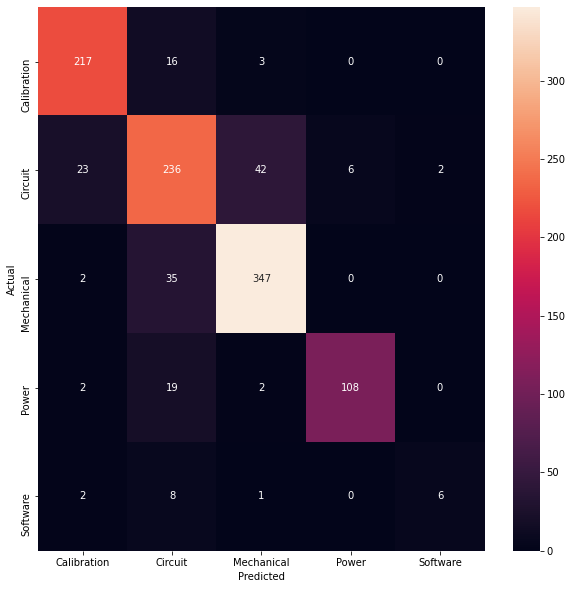

In [12]:
model = LogisticRegression(random_state=0)
X_train, X_test, y_train, y_test, indices_train, indices_test =train_test_split(features, 
                                            labels,df.index ,
                                            test_size=0.2, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
#rename=['Circuit','Mechanical','Calibration','Power','Software']
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Device_Problems.values, yticklabels=category_id_df.Device_Problems.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [13]:
from sklearn.metrics import accuracy_score,classification_report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.8486536675951718
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       236
           1       0.75      0.76      0.76       309
           2       0.88      0.90      0.89       384
           3       0.95      0.82      0.88       131
           4       0.75      0.35      0.48        17

    accuracy                           0.85      1077
   macro avg       0.84      0.75      0.78      1077
weighted avg       0.85      0.85      0.85      1077



# Linear Kernel SVM

(4306, 5258) (1077, 5258) (4306,) (1077,)


Text(0.5, 69.0, 'Predicted')

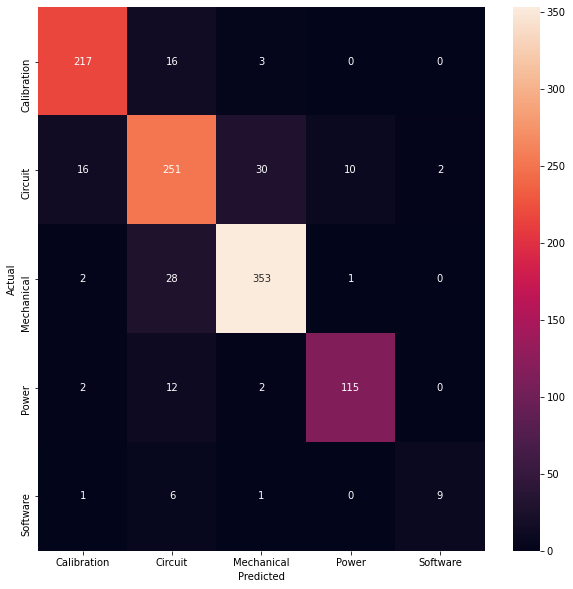

In [14]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test =train_test_split(features, 
                                            labels,df.index ,
                                            test_size=0.2, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
#rename=['Circuit','Mechanical','Calibration','Power','Software']
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Device_Problems.values, yticklabels=category_id_df.Device_Problems.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Select SVC for our Multiclass Text classification problem

(4306, 5258) (1077, 5258) (4306,) (1077,)
[3]


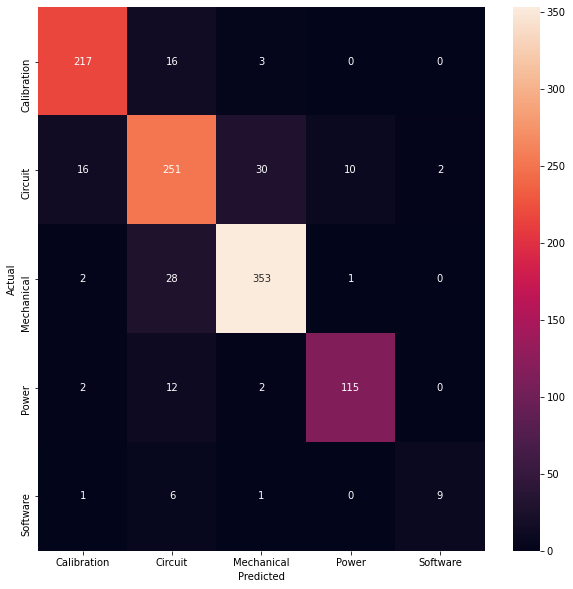

In [17]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test =train_test_split(features, 
                                            labels,df.index ,
                                            test_size=0.2, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Device_Problems.values, yticklabels=category_id_df.Device_Problems.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
print(model.predict(tfidf.transform(["the customer reported battery needs replaced it is unknown if the ventilator was being used on a patient at the time that the error was discovered confirmation has been requesteddate of event"])))

In [18]:
from sklearn.metrics import accuracy_score,classification_report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.8774373259052924
              precision    recall  f1-score   support

           0       0.91      0.92      0.92       236
           1       0.80      0.81      0.81       309
           2       0.91      0.92      0.91       384
           3       0.91      0.88      0.89       131
           4       0.82      0.53      0.64        17

    accuracy                           0.88      1077
   macro avg       0.87      0.81      0.83      1077
weighted avg       0.88      0.88      0.88      1077

